In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:
class SincDataset(Dataset):
    def __init__(self, filename):
        xy = np.loadtxt(filename, delimiter=',', dtype=np.float32)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, :-1]) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy[:, [-1]]) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import lightning as L
from linear_model import linear_decoder, linear_encoder

In [3]:
# create dataset
dataset = SincDataset('.data/sinc_data.txt')
print(len(dataset))

10000


9000


## Sinc

In [4]:
generator2 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator=generator2)

In [8]:
# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", test_loss)
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(linear_encoder, linear_decoder)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=11)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=100, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 657 K 
1 | decoder | Sequential | 658 K 
---------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.261     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/abhis/miniforge3/envs/pytorch-env/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [9]:
# load checkpoint
checkpoint = "./lightning_logs/version_8/checkpoints/epoch=14-step=22500.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=linear_encoder, decoder=linear_decoder)

# choose your trained nn.Module
trained_encoder = autoencoder.encoder
trained_decoder = autoencoder.decoder
trained_encoder.eval()


Sequential(
  (0): Linear(in_features=1000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=20, bias=True)
  (9): ReLU()
  (10): Linear(in_features=20, out_features=10, bias=True)
)

In [10]:
trainer.test(model=autoencoder, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          7.715609535807744e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 7.715609535807744e-05}]

Loss = 1.54e-05


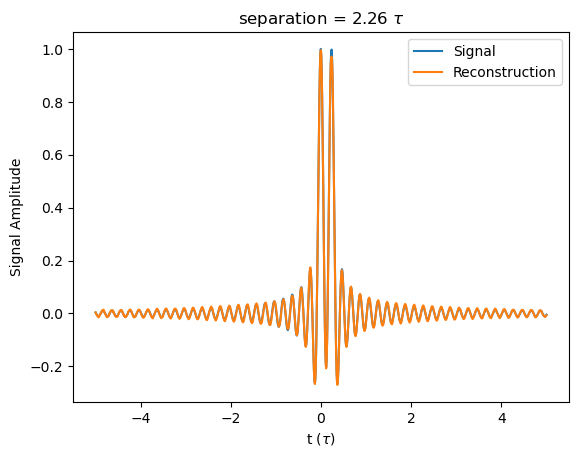

In [17]:
with torch.no_grad():
    # embed 4 fake images!
    fake_x, fake_y = test_dataset[158]
    recon = trained_decoder(trained_encoder(fake_x))
    tlist = np.linspace(-5, 5, 1000)
    fig, ax = plt.subplots()
    ax.plot(tlist, fake_x.cpu().numpy(), label="Signal")
    ax.plot(tlist, recon, label="Reconstruction")
    ax.legend()
    ax.set(
        # xlim=(-2, 2),
        xlabel=r"t ($\tau$)",
        ylabel="Signal Amplitude",
        title=rf"separation = {fake_y.detach().numpy()[0]:.2f} $\tau$",
    )
    print(f"Loss = {nn.functional.mse_loss(recon, fake_x):.2e}")

In [12]:
vis = np.asarray([(float(fake_y), float(nn.functional.mse_loss(trained_decoder(trained_encoder(fake_x)),fake_x))) for fake_x, fake_y in tqdm(test_dataset)])
vis  = vis[vis[:, 0].argsort()]
y_list = (test_dataset[:][ -1]).detach().numpy()
np.argwhere(y_list<1.44)[:, 0]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([   0,    2,    3,    4,   18,   19,   20,   24,   26,   32,   37,
         40,   43,   44,   46,   52,   54,   60,   64,   73,   75,   77,
         78,   85,   88,   89,   91,   97,   99,  102,  105,  110,  119,
        136,  142,  150,  153,  157,  160,  161,  163,  168,  172,  176,
        177,  183,  191,  192,  198,  201,  209,  210,  211,  214,  217,
        221,  228,  231,  234,  244,  245,  248,  250,  252,  254,  255,
        266,  270,  274,  277,  278,  279,  280,  285,  286,  287,  292,
        294,  296,  307,  316,  319,  326,  327,  329,  335,  337,  340,
        341,  342,  351,  360,  361,  367,  375,  379,  381,  387,  390,
        392,  395,  410,  417,  421,  422,  426,  427,  432,  435,  442,
        443,  445,  447,  451,  452,  453,  455,  457,  460,  461,  463,
        469,  483,  487,  488,  489,  490,  493,  508,  510,  521,  523,
        524,  528,  531,  536,  537,  538,  543,  544,  545,  548,  552,
        557,  559,  561,  565,  566,  568,  571,  5

[Text(0.5, 0, 'Separation $(\\tau)$'),
 Text(0, 0.5, 'Reconstruction Loss (MSE)'),
 Text(0.5, 1.0, 'Reconstruction Loss vs Test Separation'),
 (0.0, 5.0),
 (0.001, 1e-06)]

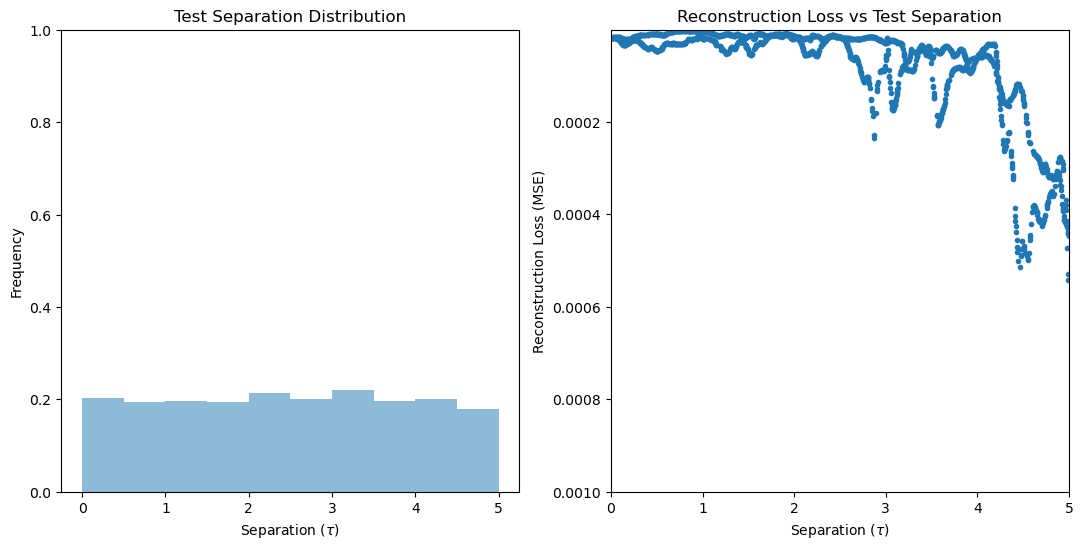

In [13]:

fig, ax = plt.subplots(1, 2, sharex=False, figsize=(13, 6))
ax[0].hist(y_list, bins=10, alpha=0.5, label='Test', density=True);
ax[0].set(xlabel=r'Separation $(\tau)$', ylabel='Frequency', title='Test Separation Distribution', ylim=(0,1))
ax[1].plot(vis[:, 0], vis[:, 1], lw=0, marker='.')
ax[1].set(xlabel=r'Separation $(\tau)$', ylabel='Reconstruction Loss (MSE)', title='Reconstruction Loss vs Test Separation', xlim=(0,5), ylim=(1e-3,1e-6))

In [14]:
fig, ax = plt.subplots()

ax
ax.

SyntaxError: invalid syntax (47845829.py, line 4)

In [13]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/ --port 6006

Launching TensorBoard...

## Superfunctions

In [8]:
class SFDataset(Dataset):
    def __init__(self, filename):
        xy = np.loadtxt(filename, delimiter=',', dtype=np.float32)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:,2000:4000]) # size [n_samples, 2000]
        # Subtract the mean and divide by the absolute max value for each row
        self.x_data = (self.x_data - self.x_data.mean(dim=1, keepdim=True)) / self.x_data.abs().max(dim=1, keepdim=True).values
        self.y_data = torch.from_numpy(xy[:, -2:]) # size [n_samples, 2]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [9]:
sf_dataset = SFDataset('.data/sf_dataset.txt')
print(len(sf_dataset))

9000


Plotting different test_signals

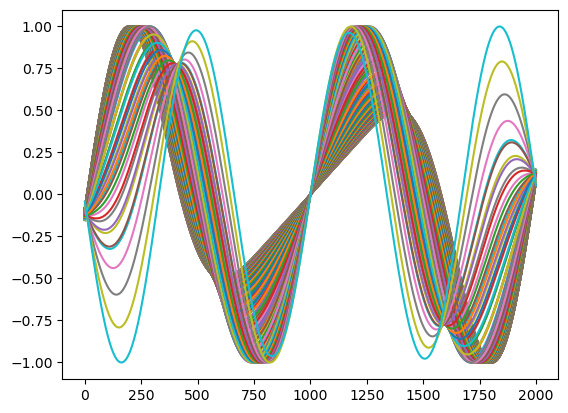

In [41]:
plt.plot((sf_dataset[::50][0]).T);

In [42]:
sf_train, sf_val, sf_test = random_split(sf_dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [43]:
SFencoder = nn.Sequential(
    nn.Linear(2000, 500),
    nn.ReLU(),
    nn.Linear(500, 250),
    nn.ReLU(),
    nn.Linear(250, 125),
    nn.ReLU(),
    nn.Linear(125, 2),
)
SFdecoder = nn.Sequential(
    nn.Linear(2, 125),
    nn.ReLU(),
    nn.Linear(125, 250),
    nn.ReLU(),
    nn.Linear(250, 500),
    nn.ReLU(),
    nn.Linear(500, 2000),
    nn.Tanh(),
)

# define the LightningModule
class SFAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", test_loss)
    

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



In [15]:

# init the autoencoder
autoencoder = SFAutoEncoder(SFencoder, SFdecoder)
train_loader = DataLoader(dataset=sf_train,
                          batch_size=4,
                          shuffle=True,
                          num_workers=11)
test_loader = DataLoader(dataset=sf_test,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)
val_loader = DataLoader(dataset=sf_val,
                          batch_size=4,
                          shuffle=False,
                          num_workers=11)
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=15, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

## Testing SF Autoencoder

In [19]:
# load checkpoint
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=18-step=34200.ckpt"
autoencoder = SFAutoEncoder.load_from_checkpoint(checkpoint, encoder=SFencoder, decoder=SFdecoder)

# choose your trained nn.Module
trained_encoder = autoencoder.encoder
trained_decoder = autoencoder.decoder
trained_encoder.eval()

Sequential(
  (0): Linear(in_features=2000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=125, bias=True)
  (5): ReLU()
  (6): Linear(in_features=125, out_features=2, bias=True)
)

In [21]:
trainer.test(model=autoencoder, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.11573660373687744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11573660373687744}]

Loss = 9.86e-02


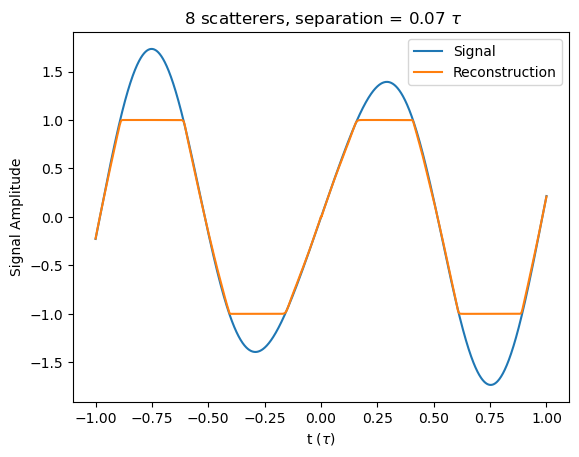

In [28]:
with torch.no_grad():
    # embed 4 fake images!
    fake_x, fake_y = sf_test[158]
    recon = trained_decoder(trained_encoder(fake_x))
    tlist = np.linspace(-1, 1, 2000)
    fig, ax = plt.subplots()
    ax.plot(tlist, fake_x.cpu().numpy(), label="Signal")
    ax.plot(tlist, recon, label="Reconstruction")
    ax.legend()
    ax.set(
        # xlim=(-2, 2),
        xlabel=r"t ($\tau$)",
        ylabel="Signal Amplitude",
        title=rf"{int(fake_y.detach().numpy()[0]):2d} scatterers, separation = {fake_y.detach().numpy()[1]:.2f} $\tau$",
    )
    print(f"Loss = {nn.functional.mse_loss(recon, fake_x):.2e}")